In [1]:
import numpy
import tqdm
import wendy
%pylab inline
import matplotlib.animation as animation
from matplotlib import cm
from IPython.display import HTML
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': True,
              'figure.figsize': [5,5],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})
_SAVE_GIFS= True
numpy.random.seed(2)

Populating the interactive namespace from numpy and matplotlib



# A self-gravitating, $\mathrm{sech}^2$ disk

A well-known solution of the one-dimensional N-body system is a $\mathrm{sech}^2$ disk. This is the equilibrium distribution for a disk with an isothermal Gaussian velocity distribution (that is, a velocity distribution that is Gaussian with the same dispersion at all locations). Because the equilibrium distribution can only be a function of the energy $E = \Phi(x)+v^2/2$ and the velocity distribution is required to be Gaussian, $f(v) \propto e^{-v^2/[2\sigma^2]}$, the equilibrium distribution function is by necessity:

$f(x,v) = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-E/\sigma^2} = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-\Phi(x)/\sigma^2-v^2/[2\sigma^2]}\,,$

with density

$\rho(x) = \rho_0\,e^{-\Phi(x)/\sigma^2}\,.$

Plugging this density into the Poisson equation allows us to solve for the potential:

$\frac{\mathrm{d}^2\Phi(x)}{\mathrm{d}x} = 4\pi G \rho(x) = 4\pi G \rho_0\,e^{-\Phi(x)/\sigma^2}\,,$

which has the solution

$\Phi(x) = 2\sigma^2 \ln\left(\mathrm{cosh}\left[\frac{x}{2 H}\right]\right)\,,$

with $H^2 = \sigma^2/[8\pi G \rho_0]$, which can be readily checked. Alternatively, $H = \sigma^2 / [2\pi G \Sigma]$, where $\Sigma$ is the total surface density. The density is then

$\rho(x) = \rho_0\,\mathrm{sech}^2\left(\frac{x}{2H}\right)\,.$


Let's check that this is indeed an equilibrium solution by initializing a system with this density and velocity distribution and testing whether (a) it remains the same over time and (b) whether the potential is correct.

In [2]:
N= 1001
# compute zh based on sigma and totmass
totmass= 1. # Sigma above
sigma= 1.
zh= sigma**2./totmass # twopiG = 1. in our units
tdyn= zh/sigma
x= numpy.arctanh(2.*numpy.random.uniform(size=N)-1)*zh*2.
v= numpy.random.normal(size=N)*sigma
v-= numpy.mean(v) # stabilize
m= numpy.ones_like(x)/N#*(1.+0.1*(2.*numpy.random.uniform(size=N)-1))

In [3]:
g= wendy.nbody(x,v,m,0.05*tdyn,maxcoll=10000000,full_output=True)

In [4]:
nt= 1000
xt= numpy.empty((N,nt+1))
vt= numpy.empty((N,nt+1))
Et= numpy.empty((nt+1))
xt[:,0]= x
vt[:,0]= v
Et[0]= wendy.energy(x,v,m)
for ii in tqdm.trange(nt):
    tx,tv,ncoll, _= next(g)
    xt[:,ii+1]= tx
    vt[:,ii+1]= tv
    Et[ii+1]= wendy.energy(tx,tv,m)
print("Encountered %i collisions" % ncoll)

100%|██████████| 1000/1000 [00:05<00:00, 182.84it/s]

Encountered 4812453 collisions


First, we check that energy was conserved:

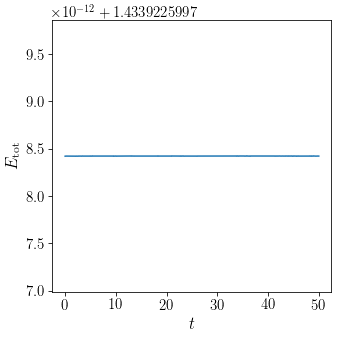

In [5]:
plot(numpy.arange(len(Et))/20.,Et)
xlabel(r'$t$')
ylabel(r'$E_{\mathrm{tot}}$')

Let's make a movie of the evolution of the system in phase space (color-coding is the initial energy, higher energy particles are also displayed as larger dots):

In [6]:
def init_anim_frame():
    line1= plot([],[])
    xlabel(r'$x$')
    ylabel(r'$v$')
    xlim(-7.99,7.99)
    ylim(-3.99,3.99)
    return (line1[0],)
figsize(6,4)
fig, ax= subplots()
c= wendy.energy(x,v,m,individual=True)
s= 5.*((c-numpy.amin(c))/(numpy.amax(c)-numpy.amin(c))*2.+1.)
line= ax.scatter(x,v,c=c,s=s,edgecolors='None',cmap=cm.jet)
txt= ax.annotate(r'$t=%.0f$' % (0.),
                 (0.95,0.95),xycoords='axes fraction',
                 horizontalalignment='right',verticalalignment='top',size=18.)
subsamp= 4
def animate(ii):
    line.set_offsets(numpy.array([xt[:,ii*subsamp],vt[:,ii*subsamp]]).T)
    txt.set_text(r'$t=%.0f$' % (ii*subsamp/20.))
    return (line,)
anim = animation.FuncAnimation(fig,animate,init_func=init_anim_frame,
                               frames=nt//subsamp,interval=40,blit=True,repeat=True)
if _SAVE_GIFS:
    anim.save('sech2disk_phasespace.gif',writer='imagemagick',dpi=80)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

The orbital structure in phase-space is nicely stratified in energy (color-coding indicates the initial energy):

(-3.99, 3.99)

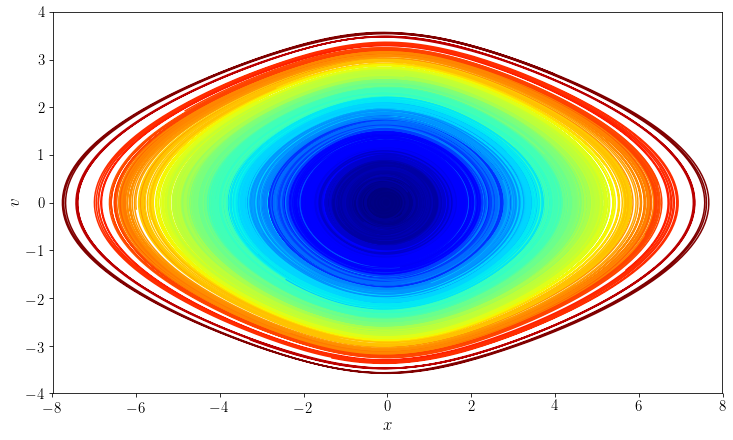

In [7]:
figsize(12,7)
for ii in range(N):
    plot(xt[ii],vt[ii],'-',color=cm.jet((c[ii]-numpy.amin(c))/(numpy.amax(c)-numpy.amin(c))))
xlabel(r'$x$')
ylabel(r'$v$')
xlim(-7.99,7.99)
ylim(-3.99,3.99)

The density profile fluctuates around the analytical $\mathrm{sech}^2$ solution (shown in blue):

In [8]:
figsize(6,4)
fig, ax= subplots()
ii= 0
a= ax.hist(xt[:,ii],bins=31,histtype='step',lw=1.,color='k',range=[-8.,8.],weights=31./16./N*numpy.ones(N))
xs= numpy.linspace(-8.,8.,101)
ax.plot(xs,totmass/4./zh/numpy.cosh(xs/2./zh)**2.,'b--',lw=2.,zorder=0)
ax.set_xlim(-8.,8.)
ax.set_ylim(10.**-3.,1.)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$',(0.95,0.95),xycoords='axes fraction',
             horizontalalignment='right',verticalalignment='top',size=18.)
subsamp= 4
def animate(ii):
    ax.clear()
    a= ax.hist(xt[:,ii],bins=31,histtype='step',lw=1.,color='k',range=[-8.,8.],weights=31./16./N*numpy.ones(N))
    xs= numpy.linspace(-8.,8.,101)
    ax.plot(xs,totmass/4./zh/numpy.cosh(xs/2./zh)**2.,'b--',lw=2.,zorder=0)
    ax.set_xlim(-8.,8.)
    ax.set_ylim(10.**-3.,1.)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\rho(x)$')
    ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95),xycoords='axes fraction',
                horizontalalignment='right',verticalalignment='top',size=18.)
    return a[2]
anim = animation.FuncAnimation(fig,animate,#init_func=init_anim_frame,
                               frames=nt//subsamp,interval=40,blit=True,repeat=True)
if _SAVE_GIFS:
    anim.save('sech2disk_density.gif',writer='imagemagick',dpi=80)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

Similarly, the velocity distribution remains equal to the expected Gaussian distribution (shown in blue):

In [9]:
figsize(6,4)
fig, ax= subplots()
ii= 0
a= ax.hist(vt[:,ii],bins=31,histtype='step',lw=1.,color='k',range=[-4.,4.],weights=31./8./N*numpy.ones(N))
xs= numpy.linspace(-4.,4.,101)
ax.plot(xs,numpy.exp(-0.5*xs**2./sigma**2.)/numpy.sqrt(2.*numpy.pi)/sigma,'b--',lw=2.,zorder=0)
ax.set_xlim(-4.,4.)
ax.set_ylim(10.**-3.,1.)
ax.set_xlabel(r'$v$')
ax.set_ylabel(r'$f(v)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$',(0.95,0.95),xycoords='axes fraction',
             horizontalalignment='right',verticalalignment='top',size=18.)
subsamp= 4
def animate(ii):
    ax.clear()
    a= ax.hist(vt[:,ii],bins=31,histtype='step',lw=1.,color='k',range=[-4.,4.],weights=31./8./N*numpy.ones(N))
    xs= numpy.linspace(-4.,4.,101)
    ax.plot(xs,numpy.exp(-0.5*xs**2./sigma**2.)/numpy.sqrt(2.*numpy.pi)/sigma,'b--',lw=2.,zorder=0)
    ax.set_xlim(-4.,4.)
    ax.set_ylim(10.**-3.,1.)
    ax.set_xlabel(r'$v$')
    ax.set_ylabel(r'$f(v)$')
    ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95),xycoords='axes fraction',
                horizontalalignment='right',verticalalignment='top',size=18.)
    return a[2]
anim = animation.FuncAnimation(fig,animate,#init_func=init_anim_frame,
                               frames=nt//subsamp,interval=40,blit=True,repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

The potential essentially does not deviate from the analytical solution (shown in blue):

In [10]:
ys= numpy.linspace(-8.99,8.99,1001)
def init_anim_frame():
    line1= plot([],[])
    xlabel(r'$x$')
    ylabel(r'$\Phi(x)$')
    xlim(-9.99,9.99)
    ylim(-1.,9.9)
    return (line1[0],)
figsize(6,4)
fig, ax= subplots()
line,= ax.plot(ys,wendy.potential(ys,xt[:,ii],vt[:,ii],m)-wendy.potential(0.,xt[:,ii],vt[:,ii],m),'k-',zorder=1)
xs= numpy.linspace(-9.,9.,101)
line2,= ax.plot(xs,2.*sigma**2.*numpy.log(numpy.cosh(xs/2./zh)),'b--',zorder=0,lw=2.)
txt= ax.annotate(r'$t=%.0f$' % (0.),
                 (0.95,0.95),xycoords='axes fraction',
                 horizontalalignment='right',verticalalignment='top',size=18.)
subsamp= 4
def animate(ii):
    line.set_ydata(wendy.potential(ys,xt[:,ii*subsamp],vt[:,ii*subsamp],m)
                   -wendy.potential(0.,xt[:,ii*subsamp],vt[:,ii*subsamp],m))
    txt.set_text(r'$t=%.0f$' % (ii*subsamp/20.))
    return (line,)
anim = animation.FuncAnimation(fig,animate,init_func=init_anim_frame,
                               frames=nt//subsamp,interval=40,blit=True,repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

Thus, the self-gravitating, isothermal, $\mathrm{sech}^2$ disk is indeed a self-consistent, equilibrium solution!

## Approximate solution

By solving the $N$-body problem approximately rather than exactly, we can run a much larger number of particles:

In [11]:
N= 100001
# compute zh based on sigma and totmass
totmass= 1. # Sigma above
sigma= 1.
zh= sigma**2./totmass # twopiG = 1. in our units
tdyn= zh/sigma
x= numpy.arctanh(2.*numpy.random.uniform(size=N)-1)*zh*2.
v= numpy.random.normal(size=N)*sigma
v-= numpy.mean(v) # stabilize
m= numpy.ones_like(x)/N#*(1.+0.1*(2.*numpy.random.uniform(size=N)-1))

In [12]:
g= wendy.nbody(x,v,m,0.05*tdyn,approx=True,nleap=10)

In [13]:
nt= 1000
xt= numpy.empty((N,nt+1))
vt= numpy.empty((N,nt+1))
Et= numpy.empty((nt+1))
xt[:,0]= x
vt[:,0]= v
Et[0]= wendy.energy(x,v,m)
for ii in tqdm.trange(nt):
    tx,tv= next(g)
    xt[:,ii+1]= tx
    vt[:,ii+1]= tv
    Et[ii+1]= wendy.energy(tx,tv,m)

100%|██████████| 1000/1000 [02:20<00:00,  6.94it/s]


Energy is still conserved, but not as good as before:

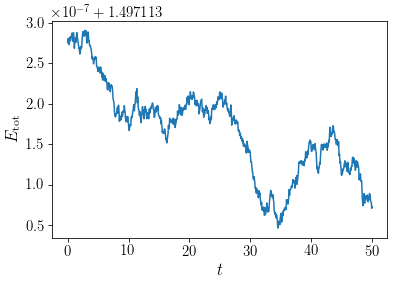

In [14]:
plot(numpy.arange(len(Et))/20.,Et)
xlabel(r'$t$')
ylabel(r'$E_{\mathrm{tot}}$')

The density is now almost exactly constant at the correct profile:

In [15]:
figsize(6,4)
fig, ax= subplots()
ii= 0
a= ax.hist(xt[:,ii],bins=51,histtype='step',lw=1.,color='k',range=[-8.,8.],weights=31./16./N*numpy.ones(N))
xs= numpy.linspace(-8.,8.,101)
ax.plot(xs,totmass/4./zh/numpy.cosh(xs/2./zh)**2.,'b--',lw=2.,zorder=0)
ax.set_xlim(-8.,8.)
ax.set_ylim(10.**-3.,1.)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$',(0.95,0.95),xycoords='axes fraction',
             horizontalalignment='right',verticalalignment='top',size=18.)
subsamp= 4
def animate(ii):
    ax.clear()
    a= ax.hist(xt[:,ii],bins=31,histtype='step',lw=1.,color='k',range=[-8.,8.],weights=31./16./N*numpy.ones(N))
    xs= numpy.linspace(-8.,8.,101)
    ax.plot(xs,totmass/4./zh/numpy.cosh(xs/2./zh)**2.,'b--',lw=2.,zorder=0)
    ax.set_xlim(-8.,8.)
    ax.set_ylim(10.**-3.,1.)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\rho(x)$')
    ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95),xycoords='axes fraction',
                horizontalalignment='right',verticalalignment='top',size=18.)
    return a[2]
anim = animation.FuncAnimation(fig,animate,#init_func=init_anim_frame,
                               frames=nt//subsamp,interval=40,blit=True,repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out